In [2]:
import pandas as pd
%load_ext autoreload
%autoreload 2

from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import napari
import colorcet as cc

import dnt

spots_directory = Path(r"D:\Tracking\DrosophilaNucleusTracking\data\spots")
save_path = Path(r"D:\Tracking\DrosophilaNucleusTracking\figures\output\movement")

include = [1, 4, 6, 7, 8, 9, 10, 11, 12, 13]

dnt.set_plot_style()
spots_dfs, metadatas, stems = dnt.load_spots_data(spots_directory, include)

df = spots_dfs[0]
cycles = [10, 11, 12, 13, 14]
earliest_frames = [25, 43, 63, 80, 55, 23, 36, 17, 50, 3]

print(df.columns)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['lightsheet_20241104_spots', 'lightsheet_20250131_spots', 'lightsheet_20250206_spots', 'lightsheet_20250414_spots', 'lightsheet_20250625_spots', 'lightsheet_20250627_spots', 'lightsheet_20250702_spots', 'lightsheet_20250704_spots', 'lightsheet_20250705_spots', 'lightsheet_bcd_20251106_spots', 'lightsheet_trk_20250318_spots', 'lightsheet_trk_20250319a_spots', 'lightsheet_trk_20250319b_spots', 'lightsheet_trk_20250321_spots', 'lightsheet_trk_20250325_spots']


reading spots dfs: 0it [00:00, ?it/s]

[  0  42  65 130 200 350] 0 320


reading spots dfs: 15it [00:01,  8.26it/s]

Index(['time_since_nc11', 'z', 'y', 'x', 'AP', 'theta', 'area', 'radius',
       'intensity_mean', 'cycle', 'display_z', 'display_y', 'display_x',
       'px_z', 'px_y', 'px_x', 'px_area', 'uv_v', 'uv_u', 'uv_z',
       'uv_distance_from_edge', 'distance_from_surface', 'uv_area',
       'area_distortion', 'mesh_name', 'interpolated', 'track_id',
       'tracklet_id', 'parent_id', 'n_children', 'n_parents', 'AP_raw',
       'AP_um', 'AP_um_centered', 'um_from_anterior', 'um_from_posterior',
       'distance_to_pole', 'time', 'trk', 'problematic', 'frame',
       'trackmate_id', 'source', 'is_parent', 'is_child', 'pseudotime',
       'distance', 'cycle_pseudotime', 'dx', 'dy', 'dz', 'dAP', 'dtheta',
       'dtot', 'dAP_abs'],
      dtype='object')


In [82]:
metadatas

[{'anterior': np.int32(253),
  'cycle_starts': array([  0,  50,  80, 140, 200, 280], dtype=int32),
  'flip_dv': np.False_,
  'posterior': np.int32(-226),
  'seconds_per_frame': np.int32(20),
  'stem': 'lightsheet_20250414',
  'surface_uv_z': np.int32(12),
  'trk': np.False_,
  'um_per_px': np.float64(0.525)}]

In [4]:
import napari
import colorcet as cc
viewer = napari.Viewer(ndisplay=3)
colors = cc.glasbey
face_colors = [colors[int(tid) % len(colors)] for tid in df["track_id"].values]
viewer.add_points(df[["frame", "z", "y", "x"]].values, face_color=face_colors, size=df["radius"]*2.0, name="all_spots", border_color="k", border_width=0.2)
napari.run()

In [3]:
df = spots_dfs[0]
earliest_frame = 55
# earliest_frame = 48
# earliest_frame = 43
df = df[df["frame"] >= earliest_frame]

173.46719866555634


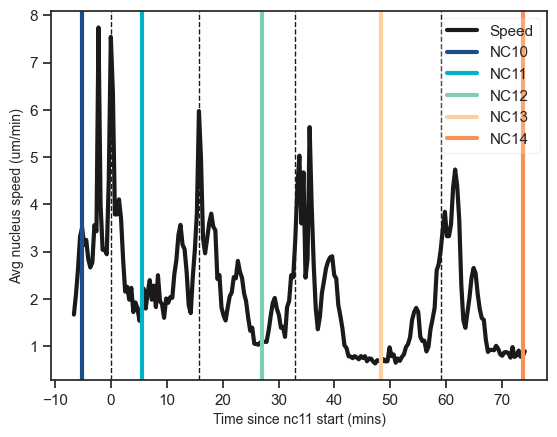

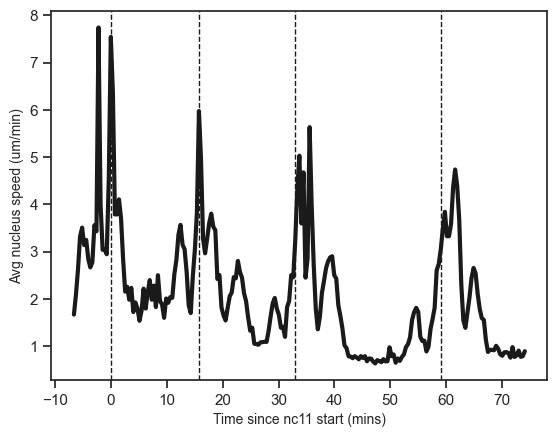

In [3]:
min_mvmt_frames, times = dnt.find_stationary_timepoints(df)

print(df.groupby("frame")["dtot"].mean().sum()*60*22/60)

for plot_timepoints in [True, False]:

    sns.lineplot(df, x="time_since_nc11", y=df["dtot"]*60, errorbar=None, color="k", label="Speed", linewidth=3.0, legend=plot_timepoints)

    frame_cycle = df.groupby("frame")["cycle"].mean()
    for cycle in cycles[1:]:
        cycle_start = np.argmax(frame_cycle.values >= cycle - 0.5)
        plt.axvline(df["time_since_nc11"].unique()[cycle_start], color="k", linestyle="--", linewidth=1.0)

    if plot_timepoints:
        for cycle, line in zip(cycles, times):
            plt.axvline(line, color=dnt.palettes.nc[cycle], label=f"NC{cycle}", linewidth=3.0)
            plt.legend()

    plt.xlabel("Time since nc11 start (mins)")
    plt.ylabel("Avg nucleus speed (um/min)")


    plt.savefig(save_path / "density" / f"speed_{metadatas[0]['stem']}{'_timepoints' if plot_timepoints else ''}.png", dpi=300)

    plt.show()

# sns.lineplot(df, x="time_since_nc11", y="cycle", errorbar=None)

In [17]:
import pandas as pd

with_napari = True

gc = cc.glasbey_cool
gw = cc.glasbey_warm
autumn_cmap = ["#370617","#6a040f","#9d0208","#d00000","#dc2f02","#e85d04","#f48c06","#faa307","#ffba08"]
cmap = gc
autumn_colors = ["#4D9500","#ED9700","#FF6000","#E41F3A","#612a1b"]
cmaps = [sns.dark_palette(c, n_colors=20)[5:] for c in autumn_colors]

if with_napari:
    viewer = napari.Viewer()
    viewer.theme = "light"
    points = df[["frame", "display_z", "display_y", "display_x"]].values
    colors = [cmap[int(tid) % len(cmap)] for tid in df["track_id"].values]

    if type(colors[0]) is str:
        colors_floats = [(int(c[1:3], 16)/255, int(c[3:5], 16)/255, int(c[5:7], 16)/255) for c in colors]
    else:
        colors_floats = [(r, g, b) for r, g, b in colors]

    viewer.add_points(points, face_color=colors_floats, size=df["radius"]*2.0, name="all_spots", border_color="k", border_width=0.2)
    napari.run()


for i, (cycle, frame) in enumerate(zip(cycles, min_mvmt_frames)):

    points = df[df["frame"] == frame][["z", "y", "x"]].values
    mesh = dnt.mesh_from_points(points)
    areas_normed = dnt.mesh_area_density(mesh, points)
    # uncomment to save mesh
    mesh.write_obj(save_path / "meshes2" / f"cycle_{cycle}.obj")

    track_ids = df[df["frame"] == frame]["track_id"].values

    # cmap = cmaps[i % len(cmaps)]
    colors = [cmap[int(tid) % len(cmap)] for tid in track_ids]
    # print(type(colors[0]))
    if type(colors[0]) is str:
        colors_floats = [(int(c[1:3], 16)/255, int(c[3:5], 16)/255, int(c[5:7], 16)/255) for c in colors]
    else:
        colors_floats = [(r, g, b) for r, g, b in colors]

    valid = pd.Series(np.arange(len(points))).isin(np.unique(mesh.faces))
    blender_save = pd.DataFrame(np.array(colors_floats)[valid], columns=["R", "G", "B"])
    blender_save["track_id"] = track_ids[valid]

    blender_save.to_csv(save_path / "meshes2" / f"cycle_{cycle}_colors.csv", index=False)


In [2]:
import pandas as pd
from tqdm import tqdm

with_napari = True
mesh_path = save_path / "all_meshes"

gc = cc.glasbey_cool
gw = cc.glasbey_warm
autumn_cmap = ["#370617","#6a040f","#9d0208","#d00000","#dc2f02","#e85d04","#f48c06","#faa307","#ffba08"]
cmap = gc
autumn_colors = ["#4D9500","#ED9700","#FF6000","#E41F3A","#612a1b"]
cmaps = [sns.dark_palette(c, n_colors=20)[5:] for c in autumn_colors]

for i, frame in tqdm(enumerate(df["frame"].unique())):

    points = df[df["frame"] == frame][["z", "y", "x"]].values
    mesh = dnt.mesh_from_points(points)
    areas_normed = dnt.mesh_area_density(mesh, points)
    # uncomment to save mesh
    mesh.write_obj(mesh_path / f"frame_{frame}.obj")

    track_ids = df[df["frame"] == frame]["track_id"].values

    # cmap = cmaps[i % len(cmaps)]
    colors = [cmap[int(tid) % len(cmap)] for tid in track_ids]
    # print(type(colors[0]))
    if type(colors[0]) is str:
        colors_floats = [(int(c[1:3], 16)/255, int(c[3:5], 16)/255, int(c[5:7], 16)/255) for c in colors]
    else:
        colors_floats = [(r, g, b) for r, g, b in colors]

    valid = pd.Series(np.arange(len(points))).isin(np.unique(mesh.faces))
    blender_save = pd.DataFrame(np.array(colors_floats)[valid], columns=["R", "G", "B"])
    blender_save["track_id"] = track_ids[valid]

    blender_save.to_csv(mesh_path / f"frame_{frame}_colors.csv", index=False)


222it [00:40,  5.43it/s]


In [25]:
import matplotlib

if with_napari:
    viewer = napari.Viewer()
    viewer.theme = "light"
    points = df[["frame", "z", "y", "x"]].values
    colors = [cmap[int(tid) % len(cmap)] for tid in df["track_id"].values]

    if type(colors[0]) is str:
        print(colors[:10])
        colors_floats = [(int(c[1:3], 16)/255, int(c[3:5], 16)/255, int(c[5:7], 16)/255) for c in colors]

        colors_floats = matplotlib.colors.rgb_to_hsv(colors_floats)
        print(colors_floats[0])
        colors_floats = [(h, s, (1 + v )/ 2) for h, s, v in colors_floats]
        colors_floats = matplotlib.colors.hsv_to_rgb(colors_floats)
    else:
        colors = matplotlib.colors.rgb_to_hsv(colors)
        print(colors)
        # colors_floats = [(r, g, b) for r, g, b in colors]

    viewer.add_points(points, face_color=colors_floats, size=df["radius"]*2.2, name="all_spots", border_color="k", border_width=0.2, shading="spherical",
                      antialiasing=0.0)
    napari.run()

['#00a3c8', '#6b64ac', '#6054ae', '#54c1ae', '#4f6e77', '#797eff', '#008abf', '#a8c6d1', '#38646e', '#036750']
[0.53083333 1.         0.78431373]


In [26]:
napari_path = mesh_path / "napari_save"
napari_path.mkdir(parents=True, exist_ok=True)

for frame in tqdm(df["frame"].unique()):
    viewer.dims.set_point(0, frame)
    viewer.screenshot(napari_path / f"{frame:04d}.tif", canvas_only=True, scale=1, flash=False)

100%|██████████| 222/222 [00:12<00:00, 17.09it/s]


In [12]:
import pandas as pd

# viewer = napari.Viewer(ndisplay=3)
gc = cc.glasbey_cool
gw = cc.glasbey_warm
autumn_cmap = ["#370617","#6a040f","#9d0208","#d00000","#dc2f02","#e85d04","#f48c06","#faa307","#ffba08"]
cmap = gc
autumn_colors = ["#605E39","#D1BB00","#FFAA00","#FF5421","#993460"]
cmaps = [sns.light_palette(c, n_colors=20) for c in autumn_colors]

for i, cycle, frame in enumerate(zip(cycles, min_mvmt_frames)):

    points = df[df["frame"] == frame][["z", "y", "x"]].values
    mesh = dnt.mesh_from_points(points)
    areas_normed = dnt.mesh_area_density(mesh, points)

    valid = pd.Series(np.arange(len(points))).isin(np.unique(mesh.faces))

    values = pd.DataFrame({
        "z": points[:, 0],
        "y": points[:, 1],
        "x": points[:, 2],
        "AP": df[df["frame"] == frame]["AP"].values,
        "area_normed": areas_normed
    })

    values["AP_binned"] = values["AP"] // 0.1 * 0.1 + 0.05
    values["density"] = 1 / values["area_normed"]
    values = values[~(values["density"] > 10000)]
    values = values[values["AP_binned"].between(0, 1)]
    sns.lineplot(values, x="AP_binned", y="density", label=f"NC{cycle}", alpha=1.0, errorbar=None, estimator="median", linewidth=5.0, color=dnt.palettes.nc[cycle])

    # print average density deviation from 1.0, excluding inf
    print(np.mean(np.abs(values["density"][~(values["density"] > 10000)] - 1)))

    values["density_clipped"] = values["density"].clip(0.5, 2.0)

    colormap = sns.color_palette("viridis", as_cmap=True)
    color = colormap((values["density_clipped"] - 0.5) / 1.5)
    viewer.add_points(values[["z", "y", "x"]].values, face_color=color, size=5.0*(np.sqrt(15 - cycle)), name=f"density_cycle_{cycle}")

    # uncomment to save mesh
    mesh.write_obj(save_path / "meshes" / f"cycle_{cycle}.obj")

    track_ids = df[df["frame"] == frame]["track_id"].values
    colors = [cmap[int(tid) % len(cmap)] for tid in track_ids]
    colors_floats = [(int(c[1:3], 16)/255, int(c[3:5], 16)/255, int(c[5:7], 16)/255) for c in colors]
    d_colors = np.array(colormap(np.clip((1/areas_normed - 0.7) / 0.6)))
    print(d_colors)
    blender_save = pd.DataFrame(np.array(colors_floats)[valid], columns=["R", "G", "B"])
    blender_save["track_id"] = track_ids[valid]
    blender_save["d_r"] = d_colors[valid, 0]
    blender_save["d_g"] = d_colors[valid, 1]
    blender_save["d_b"] = d_colors[valid, 2]

    blender_save.to_csv(save_path / "meshes" / f"cycle_{cycle}_colors.csv", index=False)

plt.axhline(1.0, color="k", linestyle="--")
plt.xlabel("AP position (fraction embryo length)")
plt.ylabel("Relative density (1/area)")

plt.title(f"Relative Nucleus Density {metadatas[0]['stem']}")
plt.savefig(save_path / "density" / f"density_{metadatas[0]['stem']}.png", dpi=300)
plt.show()

# napari.run()

# density colormap
fig, ax = dnt.color_palettes.make_colormap_figure(colormap, 0.7, 1.3, "Relative Density")
ax.invert_yaxis()
plt.savefig(save_path / "density" / f"density_colormap.png", dpi=300)
plt.show()


ValueError: not enough values to unpack (expected 3, got 2)

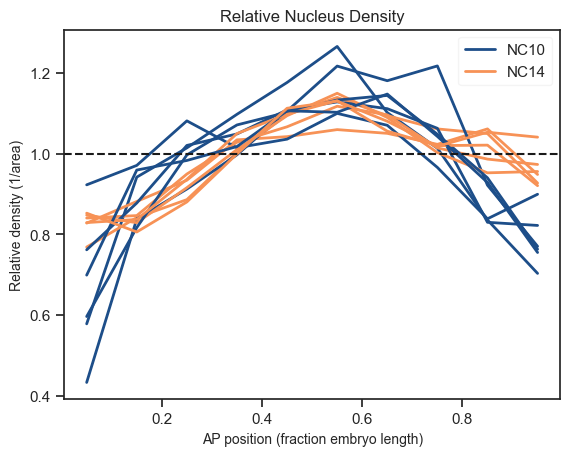

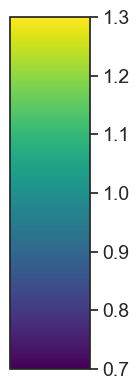

In [20]:
for i, df in enumerate(spots_dfs):
    earliest_frame = earliest_frames[i]
    df = df[df["frame"] >= earliest_frame]
    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)

    for cycle, frame in zip(cycles, min_mvmt_frames):

        if cycle in [11, 12, 13]:
            continue

        points = df[df["frame"] == frame][["z", "y", "x"]].values
        mesh = dnt.mesh_from_points(points)
        areas_normed = dnt.mesh_area_density(mesh, points)

        valid = pd.Series(np.arange(len(points))).isin(np.unique(mesh.faces))

        values = pd.DataFrame({
            "AP": df[df["frame"] == frame]["AP"].values,
            "area_normed": areas_normed
        })

        values["AP_binned"] = values["AP"] // 0.1 * 0.1 + 0.05
        values["density"] = 1 / values["area_normed"]
        values = values[~(values["density"] > 10000)]
        values = values[values["AP_binned"].between(0, 1)]
        label = f"NC{cycle}" if i == 0 else None
        sns.lineplot(values, x="AP_binned", y="density", label=label, alpha=1.0, errorbar=None, estimator="median", linewidth=2.0, color=dnt.palettes.nc[cycle])

plt.axhline(1.0, color="k", linestyle="--")
plt.xlabel("AP position (fraction embryo length)")
plt.ylabel("Relative density (1/area)")

plt.title(f"Relative Nucleus Density")
plt.savefig(save_path / "density" / f"density_all.png", dpi=300)
plt.show()

# density colormap
fig, ax = dnt.color_palettes.make_colormap_figure(colormap, 0.7, 1.3, "Relative Density")
ax.invert_yaxis()
plt.savefig(save_path / "density" / f"density_colormap.png", dpi=300)
plt.show()

In [4]:
import pandas as pd
import pymeshlab
from collections import defaultdict

nregions = 20
cutpoints = np.linspace(0, 1, nregions + 1)
cuts = {
    "anterior": [1, 4],
    "middle": [6, 14],
    "posterior": [16, 19]
}

densities_regional = defaultdict(list)
densities_axis = defaultdict(list)

for i, df in enumerate(spots_dfs):
    earliest_frame = earliest_frames[i]
    df = df[df["frame"] >= earliest_frame]
    min_mvmt_frames, times = dnt.find_stationary_timepoints(df)

    region_surface_areas = {}

    points = df[df["frame"] == min_mvmt_frames[-1]][["z", "y", "x"]].values
    APs = df[df["frame"] == min_mvmt_frames[-1]]["AP"].values

    mesh = dnt.smoothed_mesh_from_points(points)

    y_vals = np.linspace(points[:, 1].min(), points[:, 1].max(), nregions+1)
    left_sas = []

    for y in y_vals:

        ms = pymeshlab.MeshSet()
        ms.add_mesh(pymeshlab.Mesh(mesh.vertices, mesh.faces), "embryo")
        ms.generate_polyline_from_planar_section(planeaxis=1, planeoffset=y, splitsurfacewithsection=True)
        left_sas.append(ms.get_geometric_measures()["surface_area"])

    for cycle, frame in zip(cycles, min_mvmt_frames):

        df = spots_dfs[i].copy()
        APs = df[df["frame"] == frame]["AP"].values

        for region, (start, end) in cuts.items():
            region_sa = left_sas[end] - left_sas[start]
            region_n_points = ((APs >= cutpoints[start]) & (APs < cutpoints[end])).sum()
            region_density = region_n_points / region_sa

            normalized_density = region_density / (len(APs) / left_sas[-1])

            densities_regional[f"density"].append(region_density)
            densities_regional[f"sa"].append(region_sa)
            densities_regional[f"n"].append(region_n_points)
            densities_regional[f"normalized_density"].append(normalized_density)
            densities_regional[f"region"].append(region)
            densities_regional["cycle"].append(cycle)
            densities_regional["embryo"].append(metadatas[i]["stem"])

        for j in range(nregions):
            start = j
            end = j + 1
            region_sa = left_sas[end] - left_sas[start]
            region_n_points = ((APs >= cutpoints[start]) & (APs < cutpoints[end])).sum()
            region_density = region_n_points / region_sa

            normalized_density = region_density / (len(APs) / left_sas[-1])

            densities_axis[f"density"].append(region_density)
            densities_axis[f"sa"].append(region_sa)
            densities_axis[f"n"].append(region_n_points)
            densities_axis[f"normalized_density"].append(normalized_density)
            densities_axis[f"region"].append((start + end) / 2)
            densities_axis["cycle"].append(cycle)
            densities_axis["embryo"].append(metadatas[i]["stem"])

density_df = pd.DataFrame(densities_regional)
density_axis_df = pd.DataFrame(densities_axis)



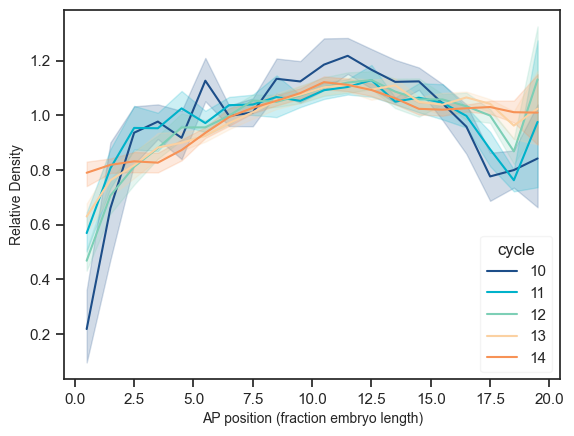

In [69]:
sns.lineplot(density_axis_df, x="region", y="normalized_density", hue="cycle", palette=dnt.palettes.nc)
plt.xlabel("AP position (fraction embryo length)")
plt.ylabel("Relative Density")
plt.savefig(save_path / "density" / f"density_by_ap.png", dpi=300)
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

11_anterior vs. 11_middle: t-test independent samples, P_val:2.137e-03 t=-4.102e+00
11_middle vs. 11_posterior: t-test independent samples, P_val:1.093e-05 t=8.069e+00
12_anterior vs. 12_middle: t-test independent samples, P_val:4.784e-06 t=-8.856e+00
12_middle vs. 12_posterior: t-test independent samples, P_val:3.778e-04 t=5.242e+00
13_anterior vs. 13_middle: t-test independent samples, P_val:6.141e-06 t=-8.612e+00
13_middle vs. 13_posterior: t-test independent samples, P_val:3.803e-02 t=2.389e+00
14_anterior vs. 14_middle: t-test independent samples, P_val:1.585e-07 t=-1.280e+01
14_middle vs. 14_posterior: t-test independent samples, P_val:2.310e-03 t=4.054e+00
10_anterior vs. 10_middle: t-test independent samples, P_val:4.132e-04 t=-5.180e+00
10_middle vs. 10_posterior: t-test independent sampl

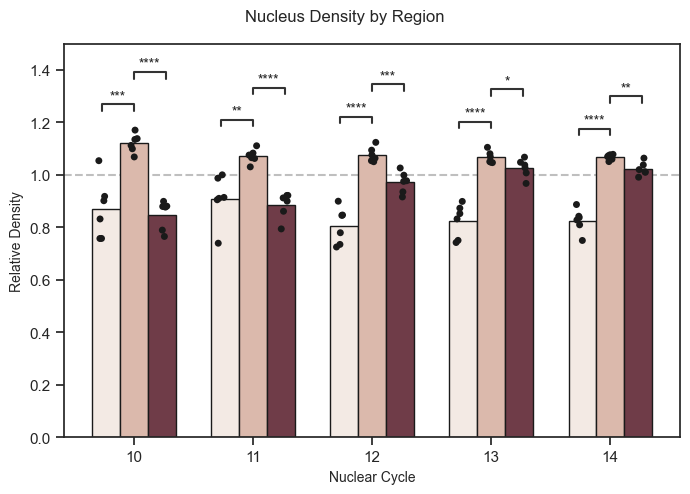

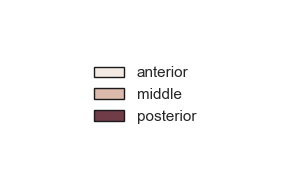

In [6]:
### plot nuclear cycle lengths
from statannotations.Annotator import Annotator


fig, ax = plt.subplots(1,1, figsize=(7, 5))

ax.axhline(1.0, color="#88888888", linestyle="--", zorder=-1)

x = "cycle"
y = "normalized_density"
hue = "region"
hue_order = ["anterior", "middle", "posterior"]
pal = ["#bce784","#5dd39e","#348aa7"]
pal = ["#773344","#e3b5a4","#f5e9e2"][::-1]

sns.barplot(data=density_df, x=x, y=y, hue=hue, palette=pal, hue_order=hue_order, ax=ax, width=0.7, errorbar=None, edgecolor="k")
sns.stripplot(data=density_df, x=x, y=y, hue=hue, palette=["k", "k", "k"], dodge=True, hue_order=hue_order, ax=ax, legend=False)

pairs = []
for cycle in cycles:
    pairs.append(((cycle, "anterior"), (cycle, "middle")))
    pairs.append(((cycle, "middle"), (cycle, "posterior")))

annot = Annotator(None, pairs)
annot.new_plot(ax, pairs, plot='boxplot',
           data=density_df, x=x, y=y, hue=hue, hue_order=hue_order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=1)
annot.apply_test().annotate()

# save legend separately
handles, labels = ax.get_legend_handles_labels()
fig_legend = plt.figure(figsize=(3, 2))
ax_legend = fig_legend.add_subplot(111)
ax_legend.legend(handles, labels, loc='center', frameon=False)
ax_legend.axis('off')
fig_legend.tight_layout()
fig_legend.savefig(save_path / "density" / "density_legend.png", dpi=300)

# turn off legend on main plot
ax.legend_.remove()
ax.set_ylabel("Relative Density")
ax.set_xlabel("Nuclear Cycle")
fig.suptitle("Nucleus Density by Region")
fig.tight_layout()
fig.savefig(save_path / "density" / f"density_by_region.png", dpi=300)

plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

anterior_10 vs. anterior_11: t-test independent samples, P_val:5.250e-01 t=-6.587e-01
middle_10 vs. middle_11: t-test independent samples, P_val:2.113e-02 t=2.732e+00
posterior_10 vs. posterior_11: t-test independent samples, P_val:2.607e-01 t=-1.192e+00
anterior_10 vs. anterior_12: t-test independent samples, P_val:2.593e-01 t=1.196e+00
middle_10 vs. middle_12: t-test independent samples, P_val:3.919e-02 t=2.371e+00
posterior_10 vs. posterior_12: t-test independent samples, P_val:1.445e-03 t=-4.350e+00
anterior_10 vs. anterior_13: t-test independent samples, P_val:4.144e-01 t=8.516e-01
middle_10 vs. middle_13: t-test independent samples, P_val:1.074e-02 t=3.127e+00
posterior_10 vs. posterior_13: t-test independent samples, P_val:6.376e-05 t=-6.562e+00
posterior_10 vs. posterior_14: t-test indepen

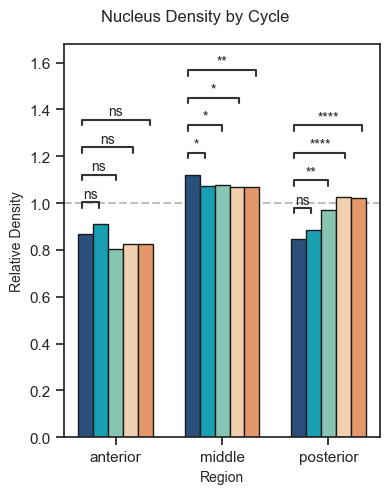

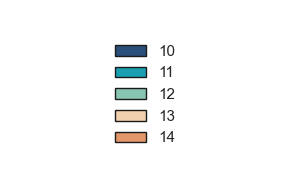

In [67]:
### plot nuclear cycle lengths
from statannotations.Annotator import Annotator


fig, ax = plt.subplots(1,1, figsize=(4, 5))

ax.axhline(1.0, color="#88888888", linestyle="--", zorder=-1)

x = "region"
y = "normalized_density"
hue = "cycle"
hue_order = cycles
pal = [dnt.palettes.nc[cycle] for cycle in cycles]

sns.barplot(data=density_df, x=x, y=y, hue=hue, palette=pal, hue_order=hue_order, ax=ax, width=0.7, errorbar=None, edgecolor="k")
# sns.swarmplot(data=density_df, x=x, y=y, hue=hue, palette=["k", "k", "k"], dodge=True, hue_order=hue_order, ax=ax, legend=False)

pairs = []
for region in regions:
    for cycle in cycles[1:]:
        pairs.append(((region, 10), (region, cycle)))

annot = Annotator(None, pairs)
annot.new_plot(ax, pairs, plot='boxplot',
           data=density_df, x=x, y=y, hue=hue, hue_order=hue_order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=1)
annot.apply_test().annotate()

# save legend separately
handles, labels = ax.get_legend_handles_labels()
fig_legend = plt.figure(figsize=(3, 2))
ax_legend = fig_legend.add_subplot(111)
ax_legend.legend(handles, labels, loc='center', frameon=False)
ax_legend.axis('off')
fig_legend.tight_layout()
fig_legend.savefig(save_path / "density" / "nc_legend.png", dpi=300)

# turn off legend on main plot
ax.legend_.remove()
ax.set_ylabel("Relative Density")
ax.set_xlabel("Region")
fig.suptitle("Nucleus Density by Cycle")
fig.tight_layout()
fig.savefig(save_path / "density" / f"density_by_nc.png", dpi=300)

plt.show()